<a id='toc'></a>

## Workflow

1. [Import](#import)
1. [Acquire Data](#acquire-data)
1. [Clean, Prep & Split Data](#clean-prep-and-split-data)
1. [Explore Data](#explore-data)

1. [Modeling](#modeling)
    - [Identify Baseline](#identify-baseline)
    - [Model on Train](#model-on-train)
    - [Model on Validate](#model-on-validate)
    - [Model on Test](#model-on-test)

7. [2nd Iteration: Acquire Data](#2nd-iteration-acquire-data)
8. [2nd Iteration: Clean, Prep & Split Data](#2nd-iteration-clean-prep-and-split-data)
9. [2nd Iteration: Explore Data](#2nd-iteration-explore-data)
    - [2nd Iteration: Hypothesis Testing](#2nd-iteration-hypothesis-testing)
10. [2nd Iteration: Feature Importance](#2nd-iteration-feature-importance)
11. [2nd Iteration: Modeling](#2nd-iteration-modeling)
    - [2nd Iteration: Train](#2nd-iteration-train)
    - [2nd Iteration: Validate](#2nd-iteration-validate)
    - [2nd Iteration: Test](#2nd-iteration-test)
    
12. [Drivers](#drivers)

13. [Conclusion](#conclusion)


 [Jump to the bottom of Repo](#bottom)

___
# <a name="import"></a>1. Import 
Import all necessary libraries and functions. 

In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd


# visualize 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt

import statsmodels.api as sm

import wrangle as w
import prepare as p
import explore as ex

plt.rc('figure', figsize=(30, 7))
# plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)
plt.rc('figure', figsize=(30, 7))
plt.rc('font', size=16)
plt.style.use('fivethirtyeight')

[Jump to Table of Contents](#toc)
___
# <a name="acquire-data"></a>2. Acquire Data
#### Reads in  `GlobalLandTemperaturesByCity.csv` data from your local file using the `get_data()` function in [`wrangle.py`](wrangle.py)

In [2]:
au = w.get_data()

[Jump to Table of Contents](#toc)
 
___
# <a name="clean-prep-and-split-data"></a>3. Clean, Prep and Split Data

In [3]:
au = w.prep_auck(au)

In [4]:
au.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1448 entries, 1893-01-01 to 2013-08-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   avg_temp  1448 non-null   float64
dtypes: float64(1)
memory usage: 22.6 KB


In [5]:
au.head()

avg_temp
dt                  
1893-01-01    18.244
1893-02-01    18.657
1893-03-01    16.520
1893-04-01    16.494
1893-05-01    15.282

In [6]:
au.isnull().sum()

avg_temp    0
dtype: int64

<AxesSubplot:xlabel='dt'>

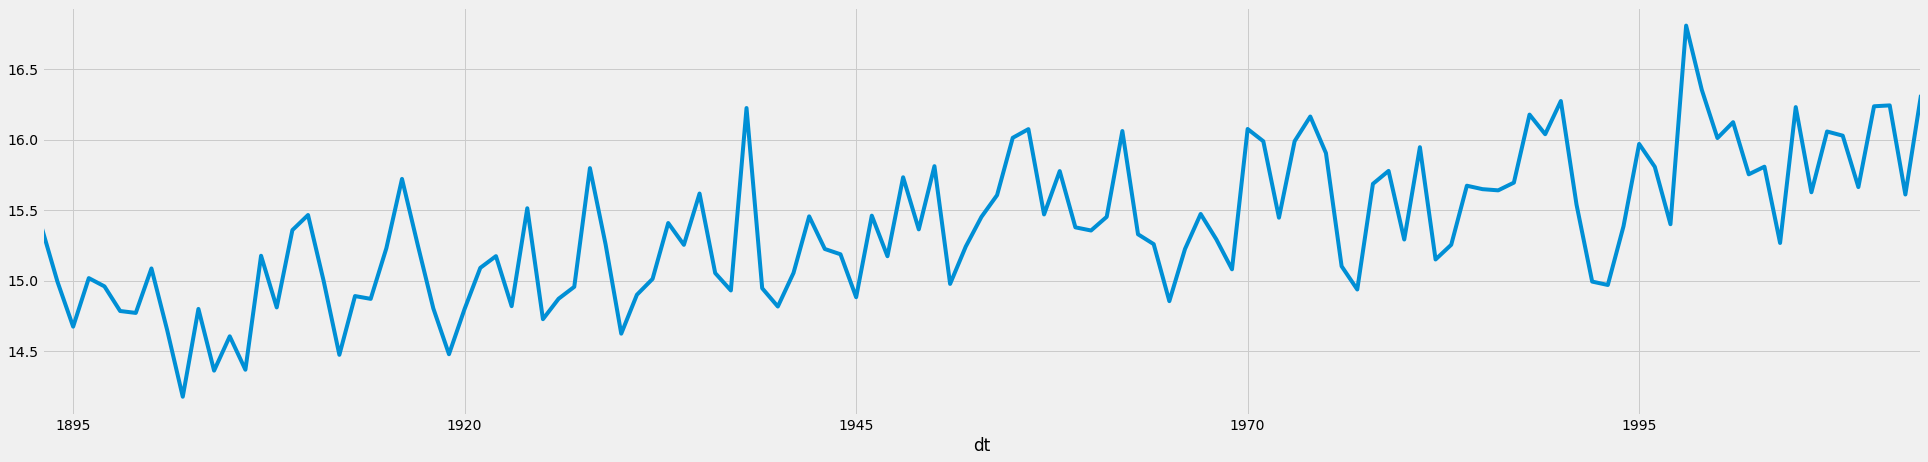

In [7]:
au.resample('Y').avg_temp.mean().plot()

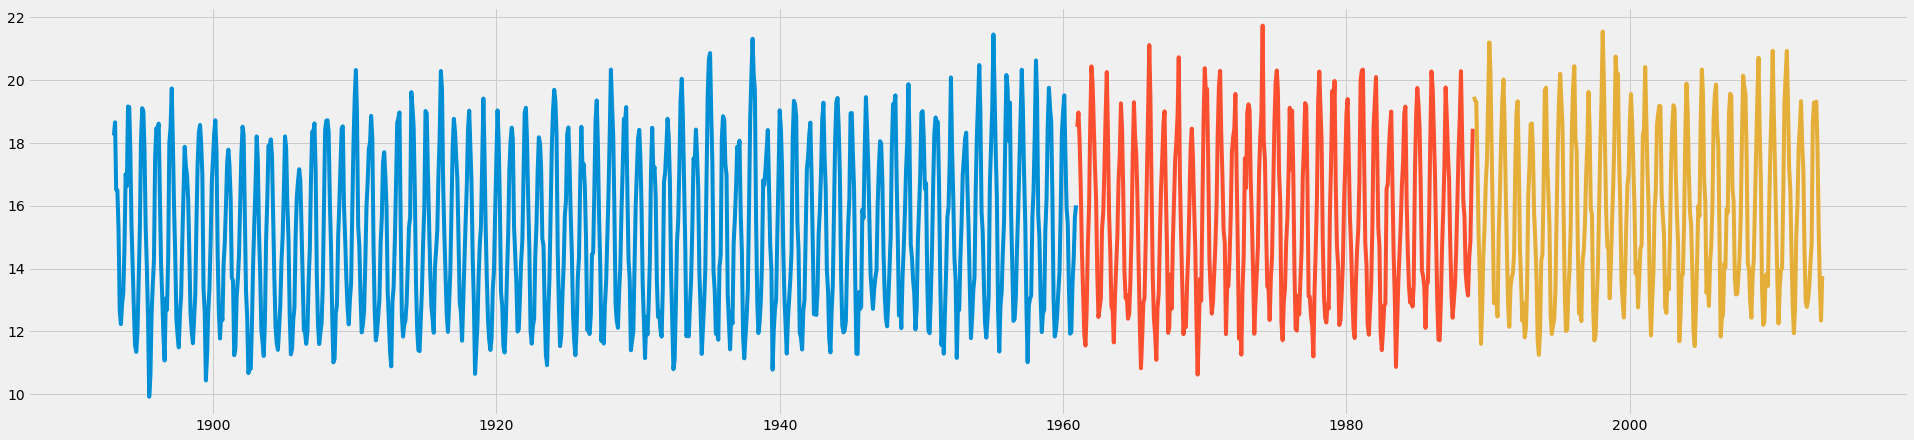

In [15]:
# Anything upto (and including) 1980 as train and rest as test

train = au[:'1960'] # includes 1960
validate = au['1961':'1988'] 
test = au['1989':]

# plot the train and test
plt.plot(train.index, train.avg_temp)
plt.plot(validate.index, validate.avg_temp)
plt.plot(test.index, test.avg_temp)

In [17]:
au.shape, train.shape, validate.shape, test.shape

((1448, 1), (816, 1), (336, 1), (296, 1))

[Jump to Table of Contents](#toc)
 
___
# <a name="explore-data"></a>4. Explore Data

<AxesSubplot:>

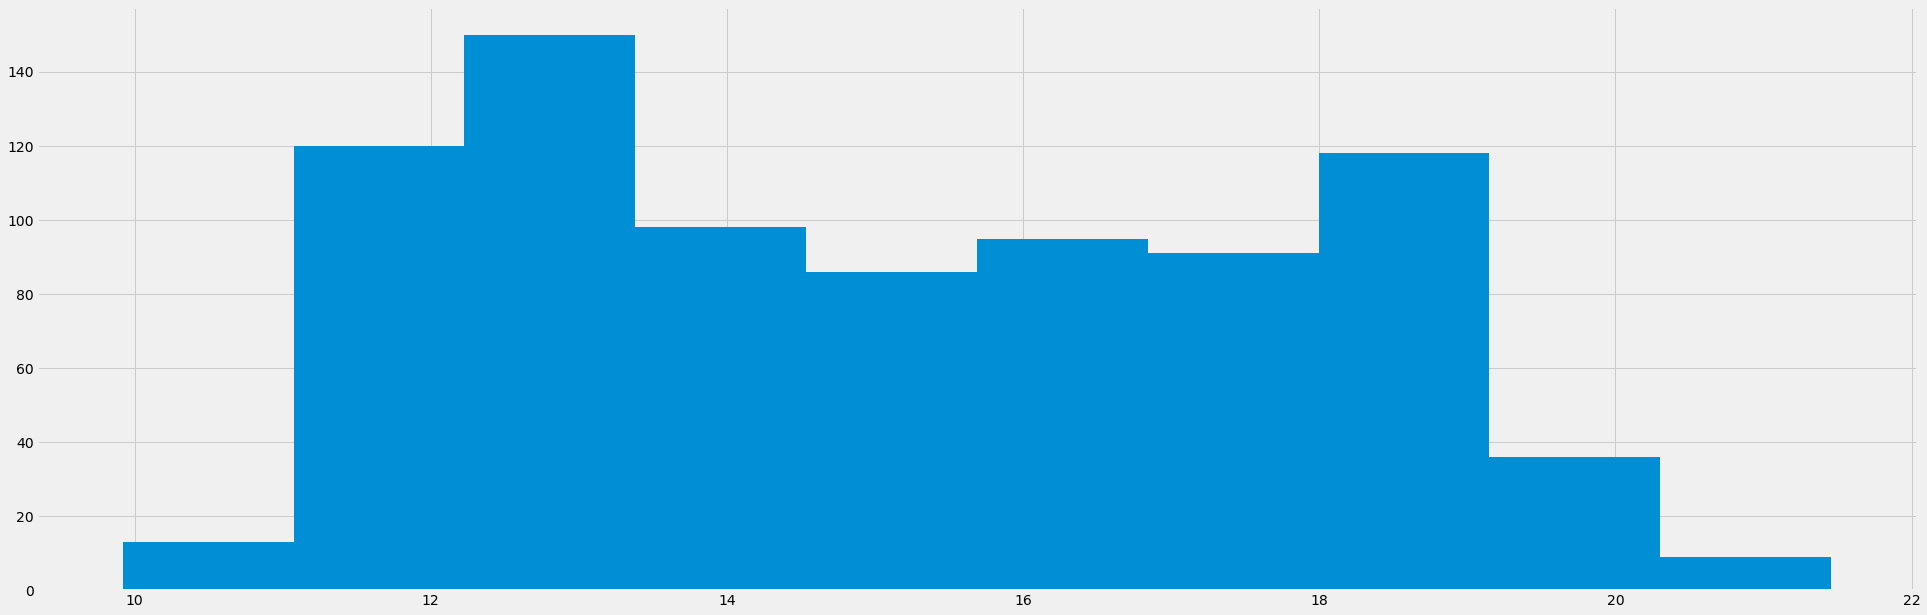

In [35]:
train.avg_temp.hist()

<AxesSubplot:xlabel='dt'>

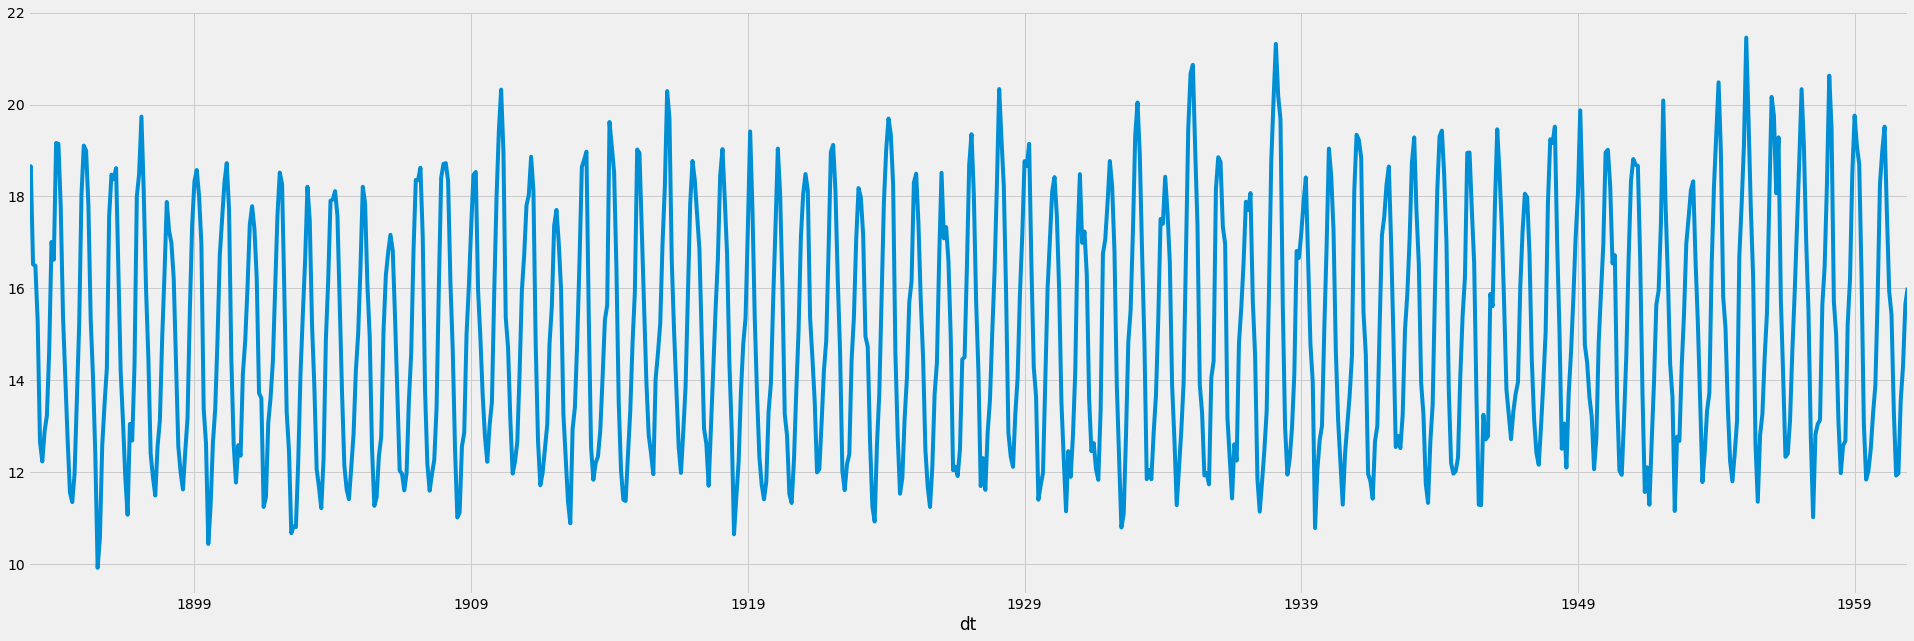

In [36]:
train.resample('M').avg_temp.mean().plot()

In [37]:
# y is the resampled daily data:

y = train.resample('D').avg_temp.mean()
y.head()

dt
1893-01-01    18.244
1893-01-02       NaN
1893-01-03       NaN
1893-01-04       NaN
1893-01-05       NaN
Freq: D, Name: avg_temp, dtype: float64

[Text(0.5, 1.0, 'Average Temperature by Month'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Temp (°C)')]

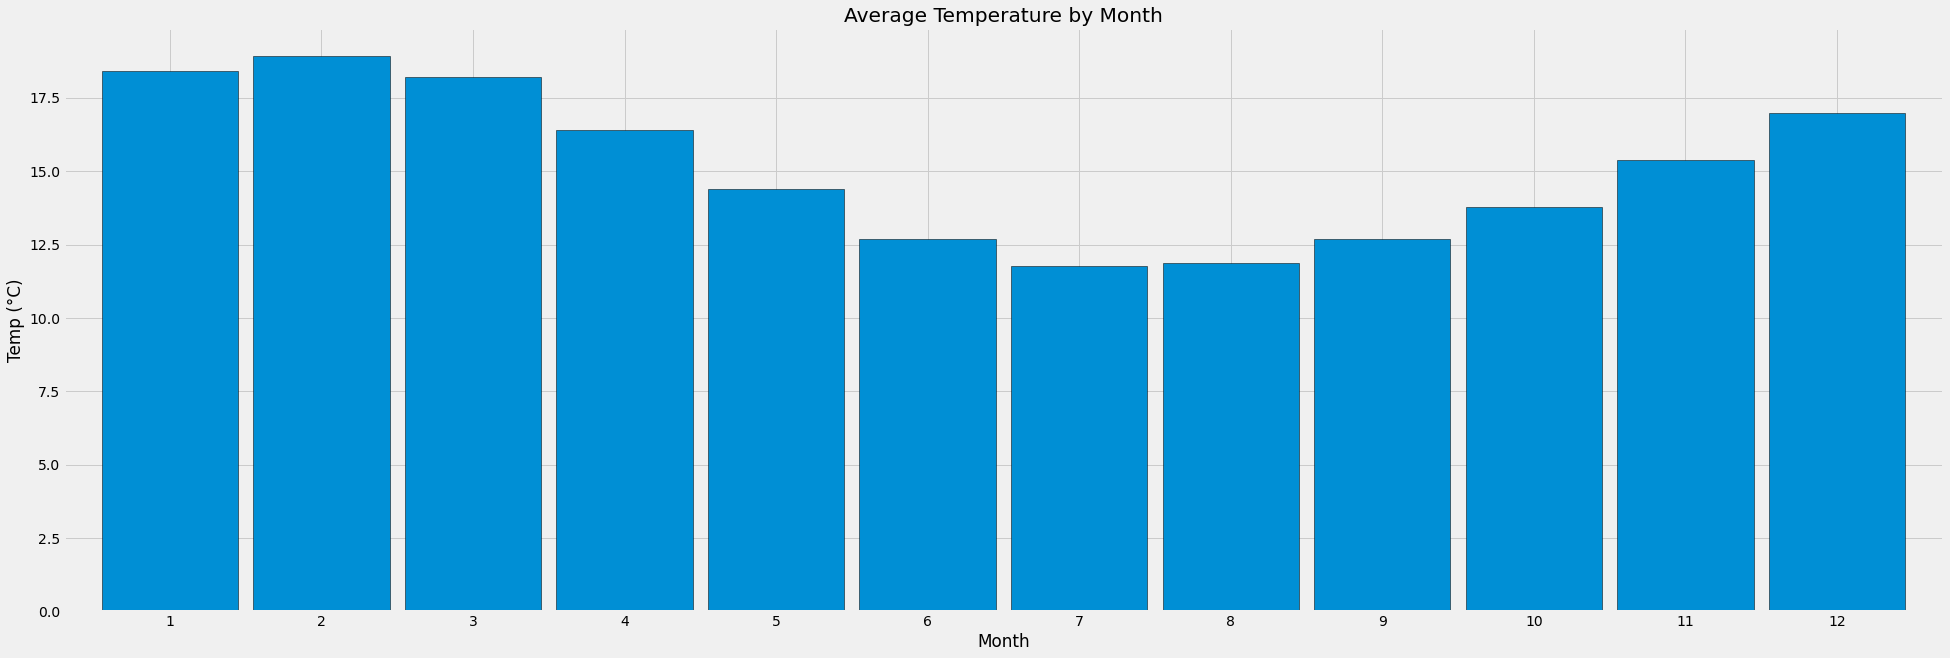

In [38]:
ax = y.groupby(y.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Temperature by Month', xlabel='Month', ylabel='Temp (°C)')

In [39]:
au.groupby('weekday').describe().T

weekday             Friday      Monday    Saturday      Sunday    Thursday  \
avg_temp count  208.000000  207.000000  207.000000  206.000000  207.000000   
         mean    15.348947   15.358899   15.411213   15.360301   15.318517   
         std      2.712545    2.648635    2.652808    2.606945    2.666192   
         min     10.798000    9.920000   10.439000   11.254000   10.579000   
         25%     12.950750   13.034000   13.005500   13.036000   12.838000   
         50%     14.721500   15.091000   15.102000   15.355000   15.205000   
         75%     17.851250   17.581500   18.012000   17.464500   17.522500   
         max     21.738000   20.937000   20.628000   21.549000   21.203000   
month    count  208.000000  207.000000  207.000000  206.000000  207.000000   
         mean     6.490385    6.434783    6.521739    6.504854    6.521739   
         std      3.473836    3.445040    3.442772    3.463746    3.451222   
         min      1.000000    1.000000    1.000000    1.000000    1.000000   
         25%      3.000000    3.500000    4.000000    4.000000    3.500000   
         50%      6.000000    6.000000    7.000000    7.000000    7.000000   
         75%      9.250000    9.000000    9.000000    9.750000    9.500000   
         max     12.000000   12.000000   12.000000   12.000000   12.000000   

weekday            Tuesday   Wednesday  
avg_temp count  205.000000  208.000000  
         mean    15.419429   15.412630  
         std      2.791743    2.589533  
         min     10.626000   10.926000  
         25%     13.048000   13.008000  
         50%     15.406000   15.209500  
         75%     17.908000   17.849500  
         max     21.456000   20.337000  
month    count  205.000000  208.000000  
         mean     6.482927    6.466346  
         std      3.472010    3.458354  
         min      1.000000    1.000000  
         25%      3.000000    3.000000  
         50%      6.000000    6.000000  
         75%      9.000000    9.000000  
         max     12.000000   12.000000

[Text(0.5, 1.0, 'Average Temperature by Weekday'),
 Text(0.5, 0, 'Weekday'),
 Text(0, 0.5, 'Temp (°C)')]

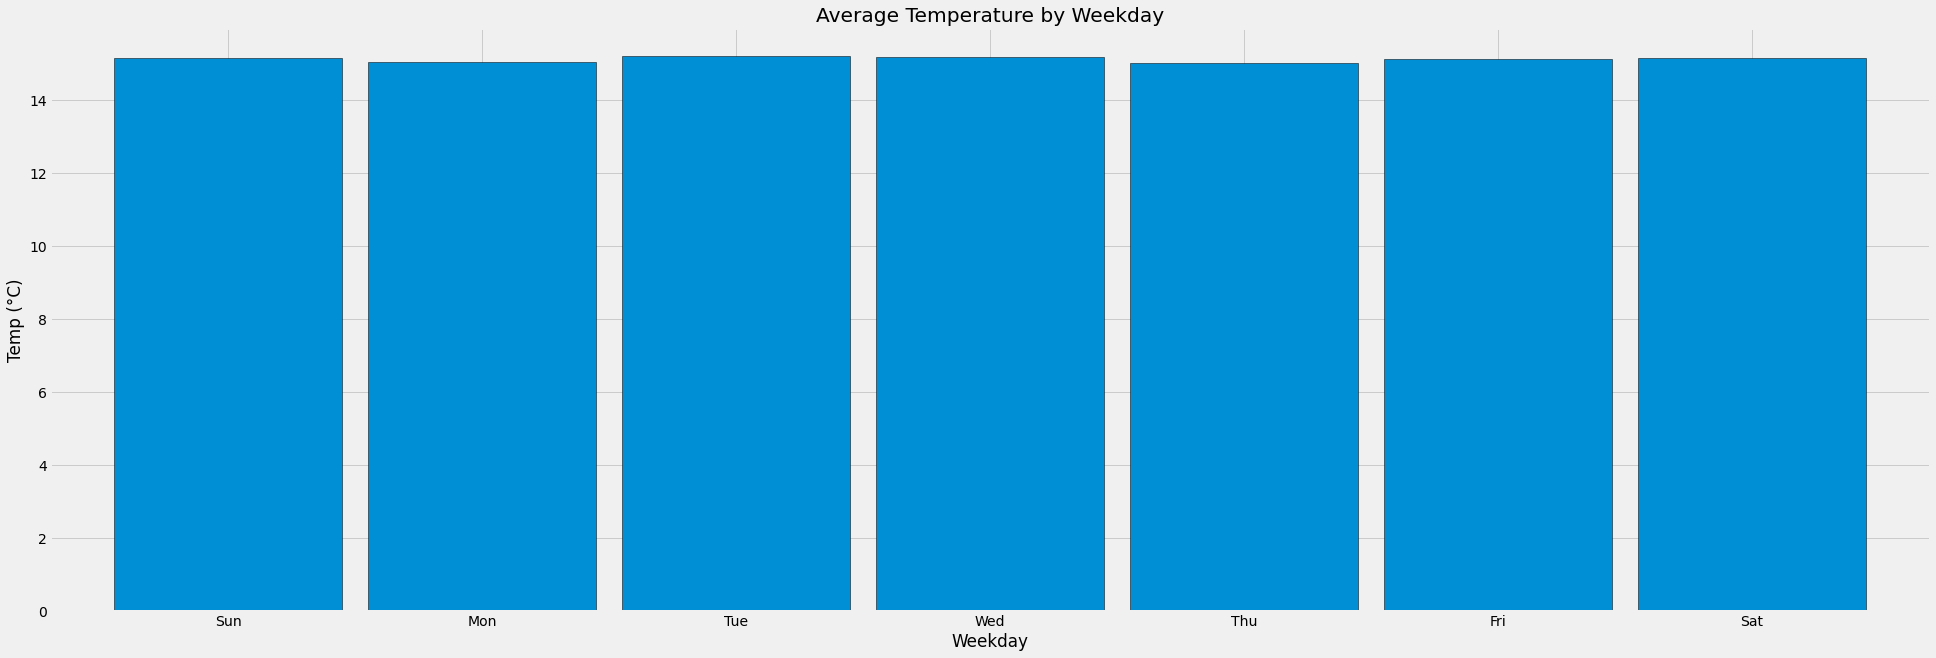

In [40]:
ax = y.groupby(y.index.strftime('%w-%a')).mean().plot.bar(width=.9, ec='black')
ax.set_xticklabels([t.get_text()[2:] for t in ax.get_xticklabels()], rotation=0)
ax.set(title='Average Temperature by Weekday', xlabel='Weekday', ylabel='Temp (°C)')

<AxesSubplot:xlabel='weekday', ylabel='avg_temp'>

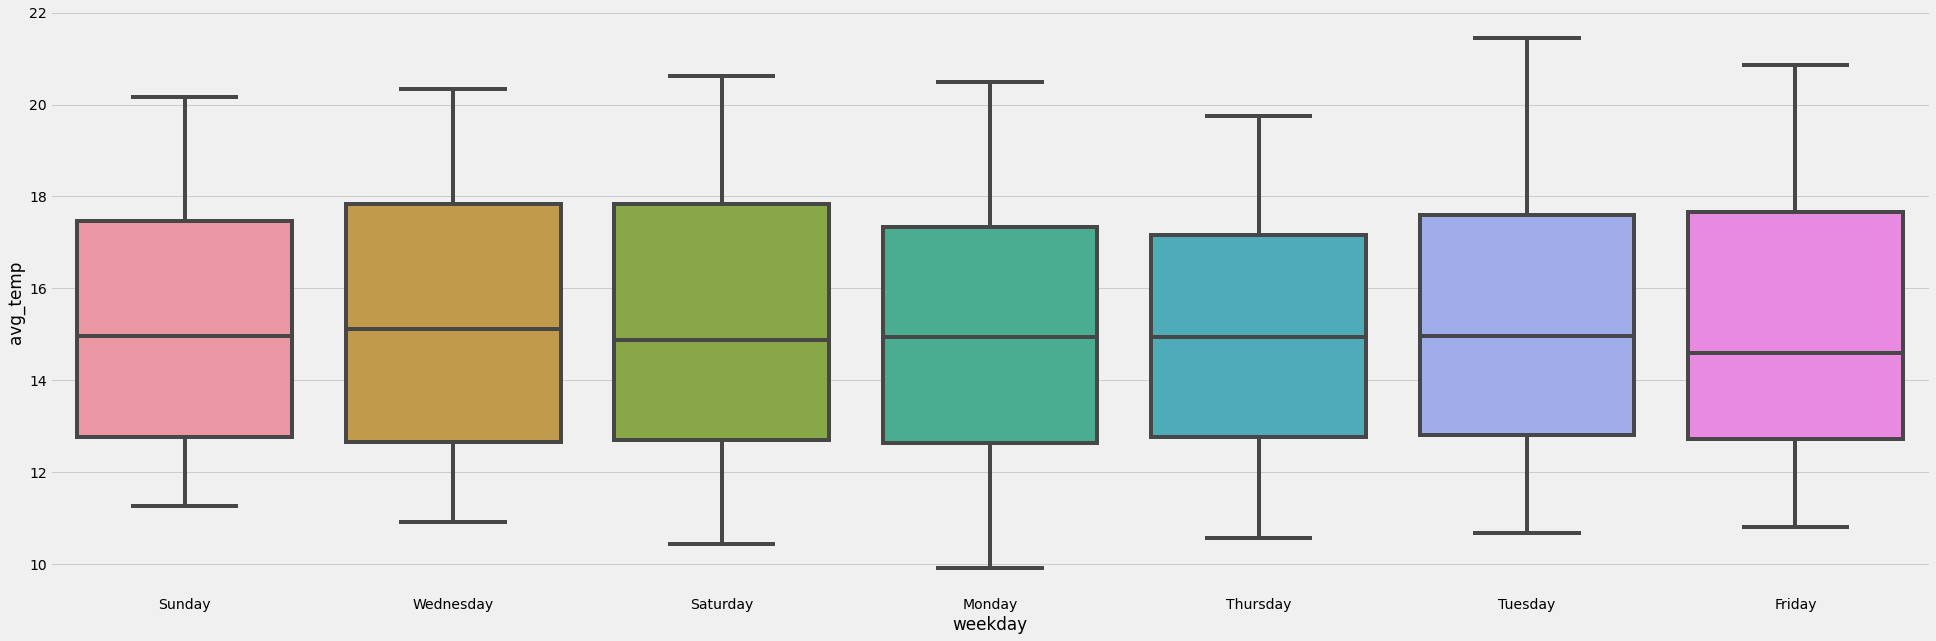

In [41]:
sns.boxplot(data = train, x = 'weekday', y = 'avg_temp')

<AxesSubplot:xlabel='month', ylabel='avg_temp'>

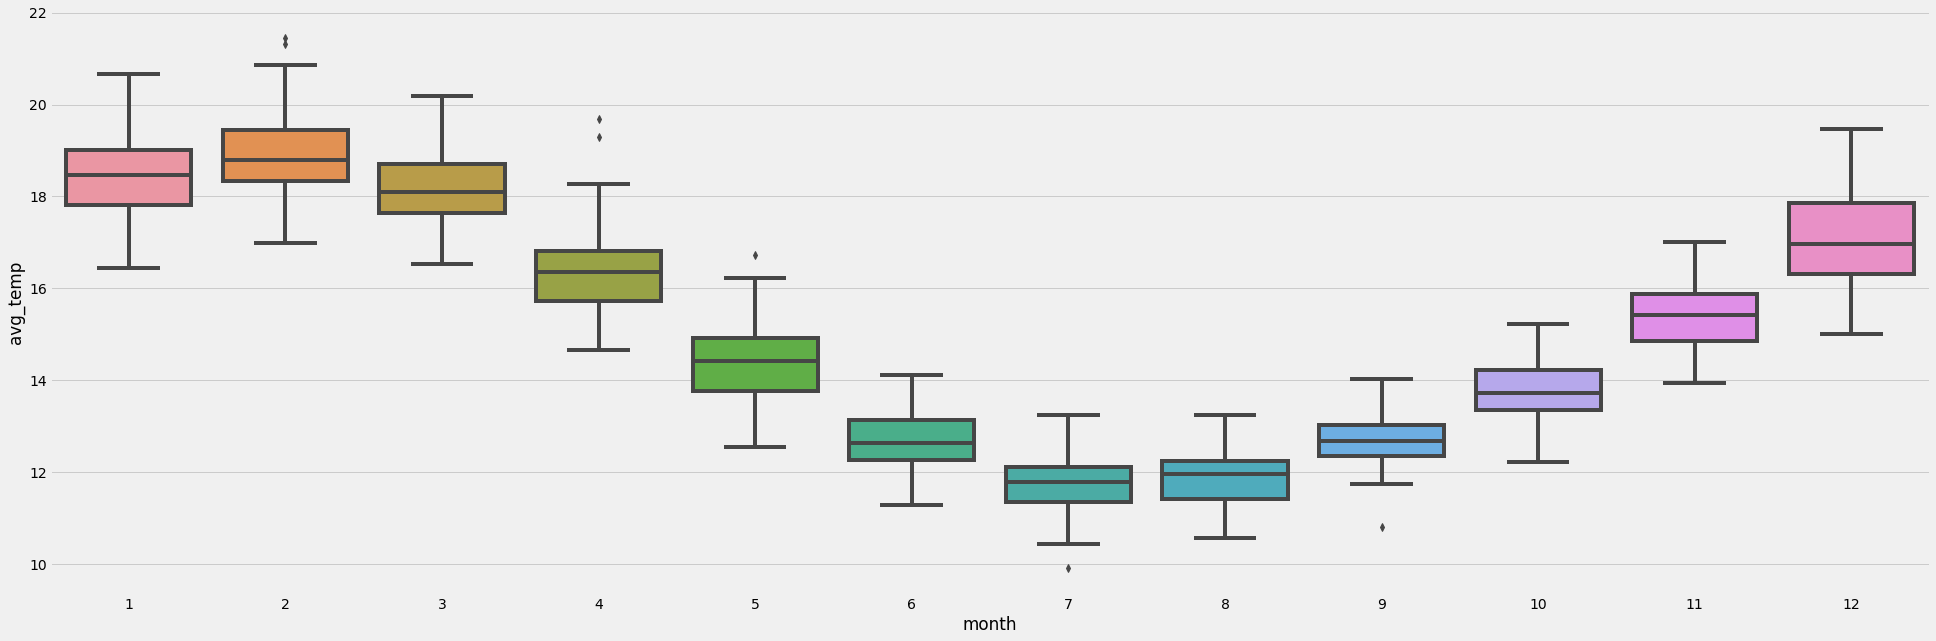

In [42]:
sns.boxplot(data = train, x = 'month', y = 'avg_temp')

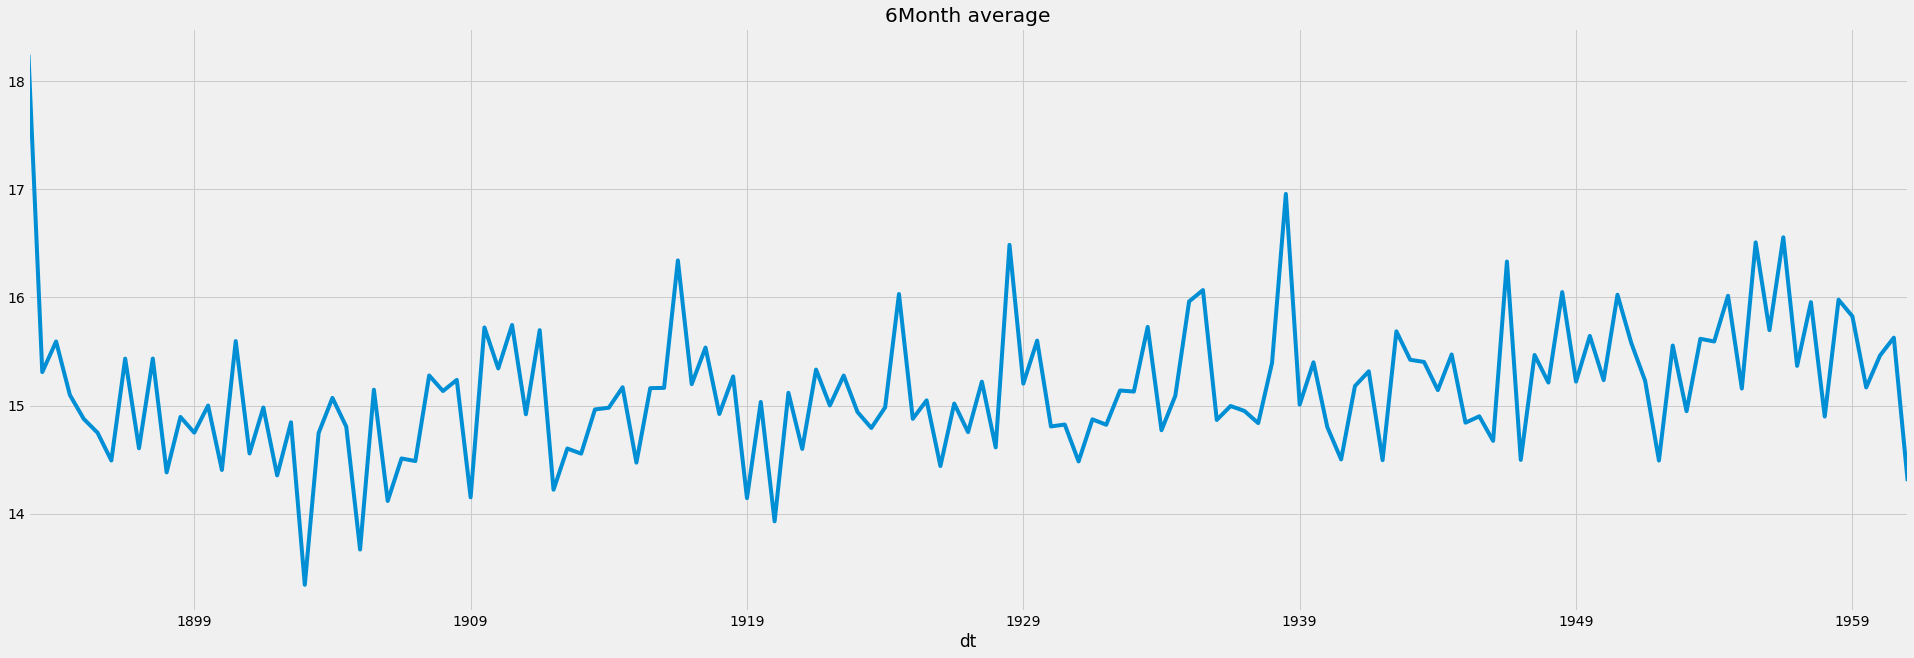

In [43]:
y.resample('6M').mean().plot(title='6Month average');

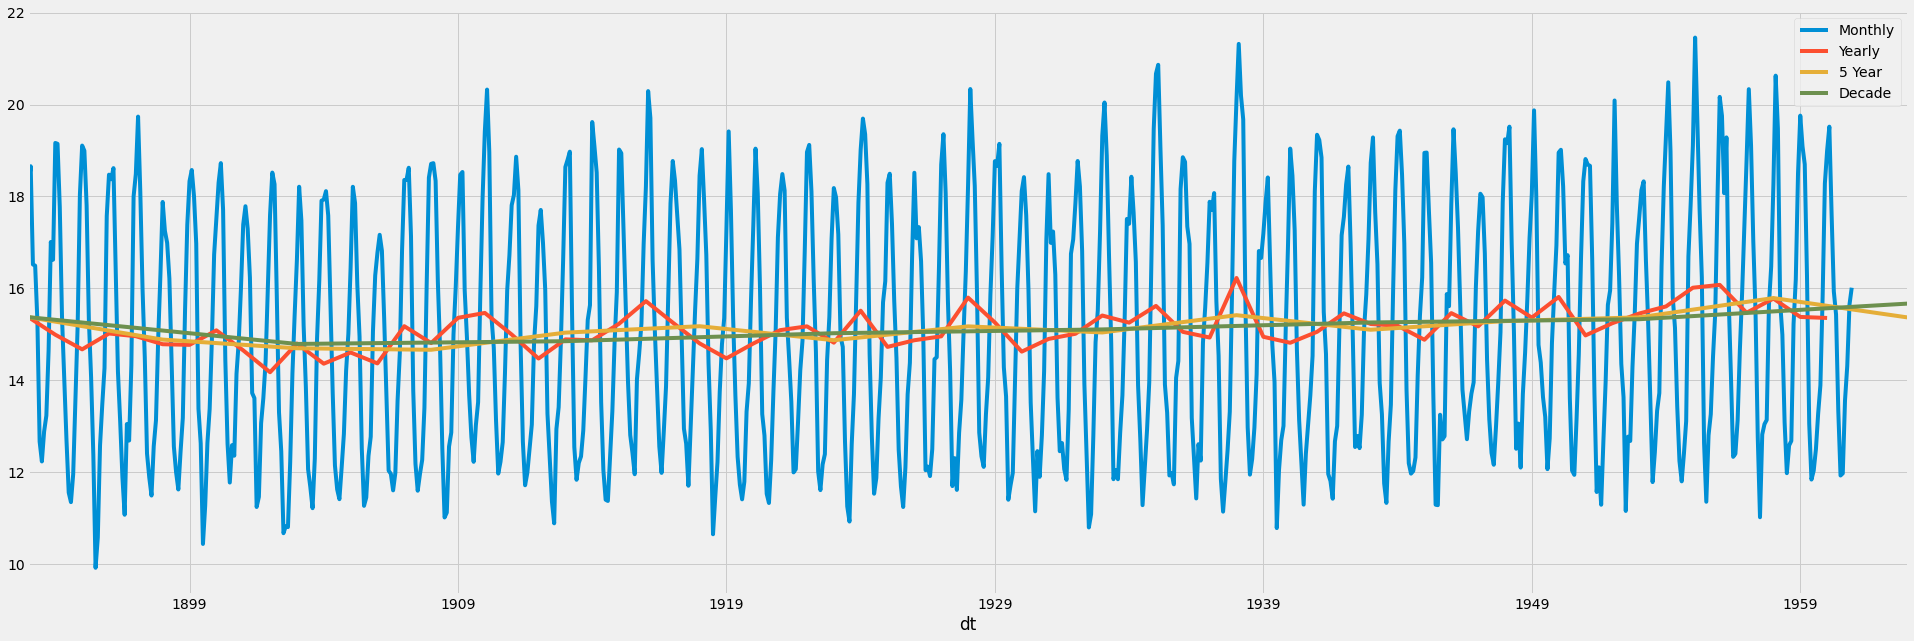

In [44]:
y.resample('M').mean().plot(label = 'Monthly')
y.resample('Y').mean().plot(label = 'Yearly')
y.resample('5Y').mean().plot(label = '5 Year')
y.resample('10Y').mean().plot(label = 'Decade')
plt.legend()

<AxesSubplot:xlabel='dt'>

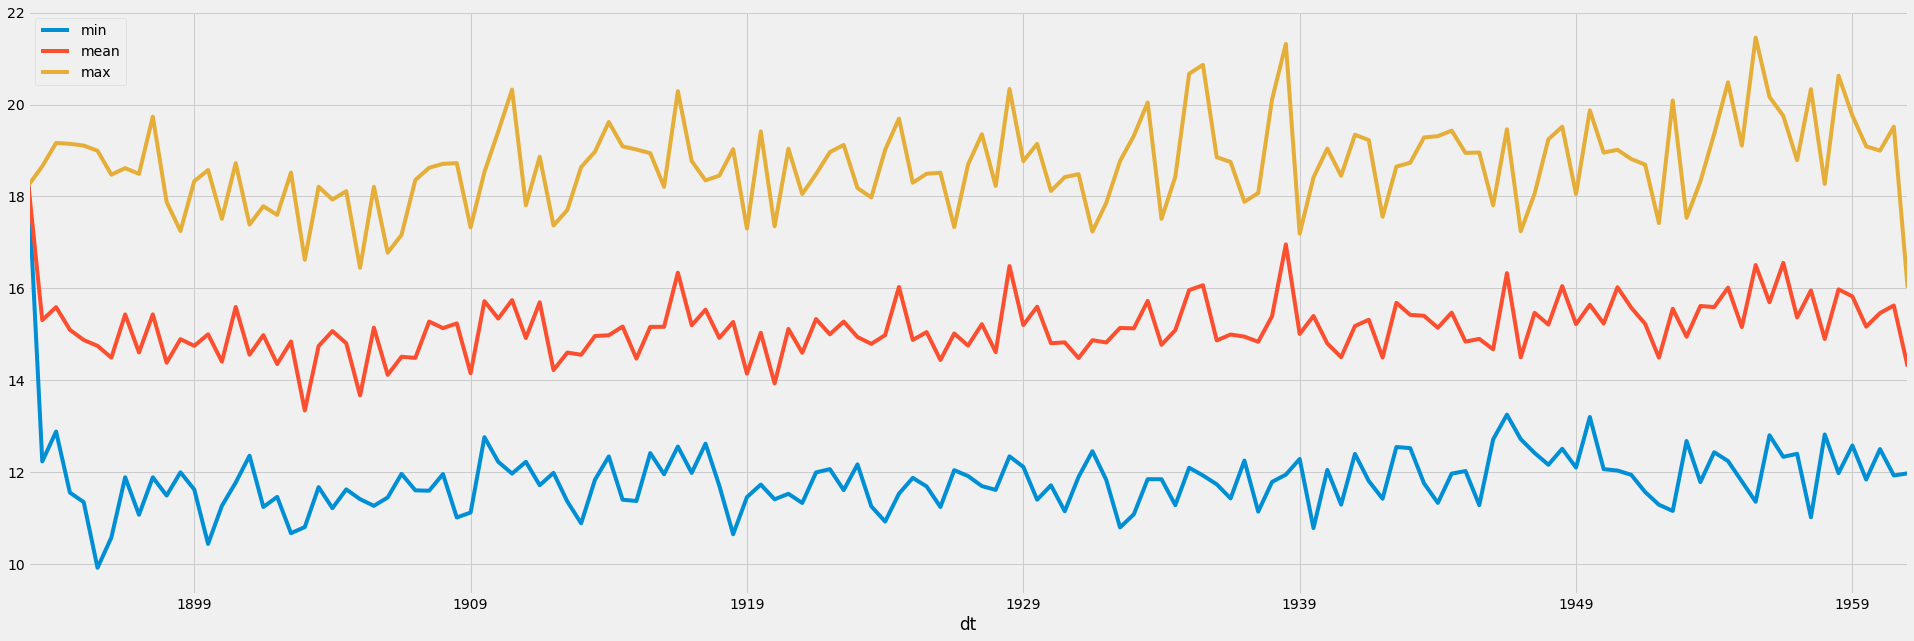

In [45]:
y.resample('6M').agg(['min', 'mean', 'max']).plot()

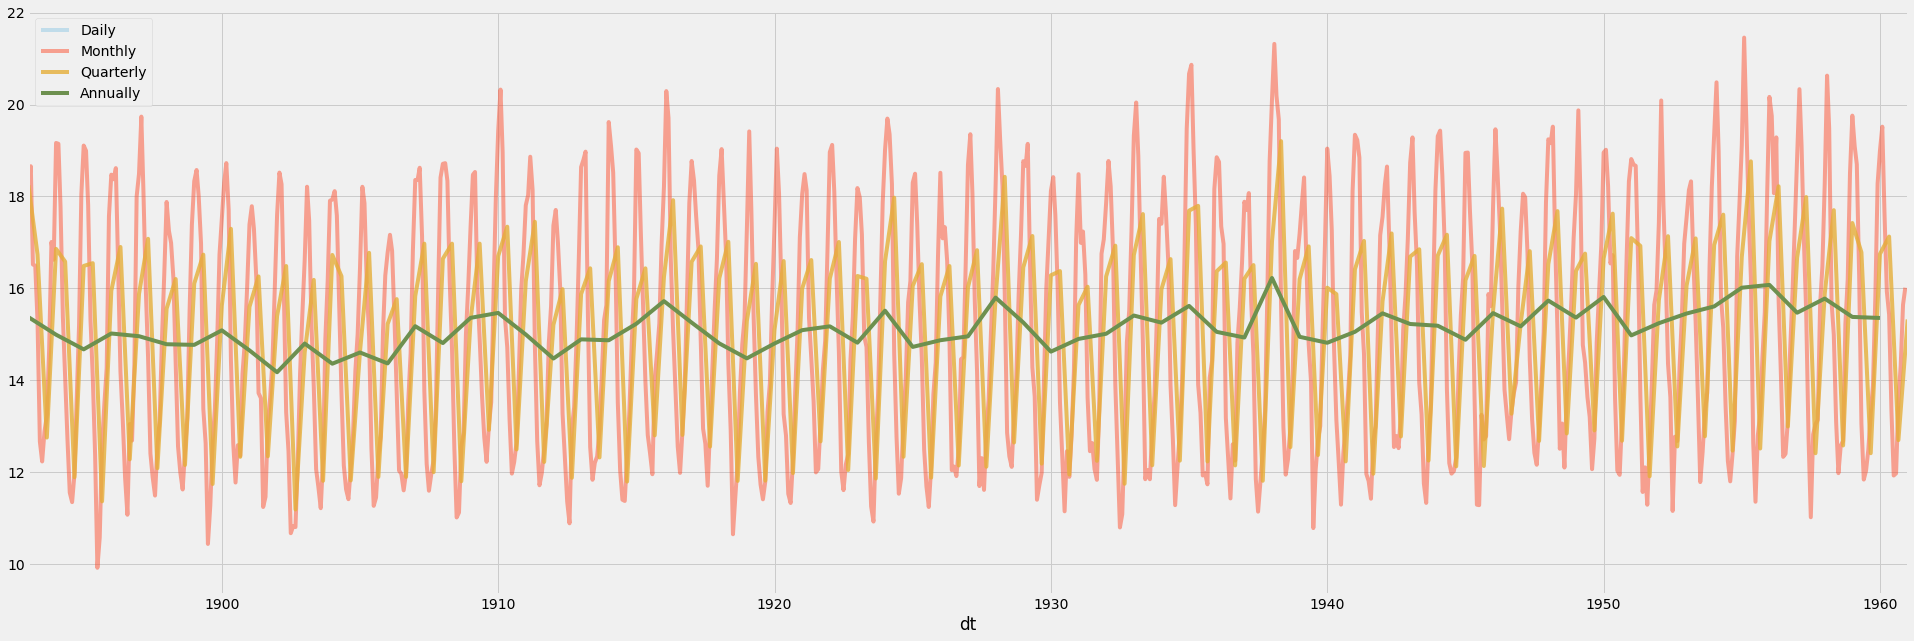

In [46]:
y.plot(alpha=.2, label='Daily')
y.resample('M').mean().plot(alpha=.5, label='Monthly')
y.resample('4M').mean().plot(alpha=.8, label='Quarterly')
y.resample('Y').mean().plot(label='Annually')
#y.resample('5Y').mean().plot(label='5-Yearly')
plt.legend()

<AxesSubplot:title={'center':'Average month-to-month change in temperature'}, xlabel='dt'>

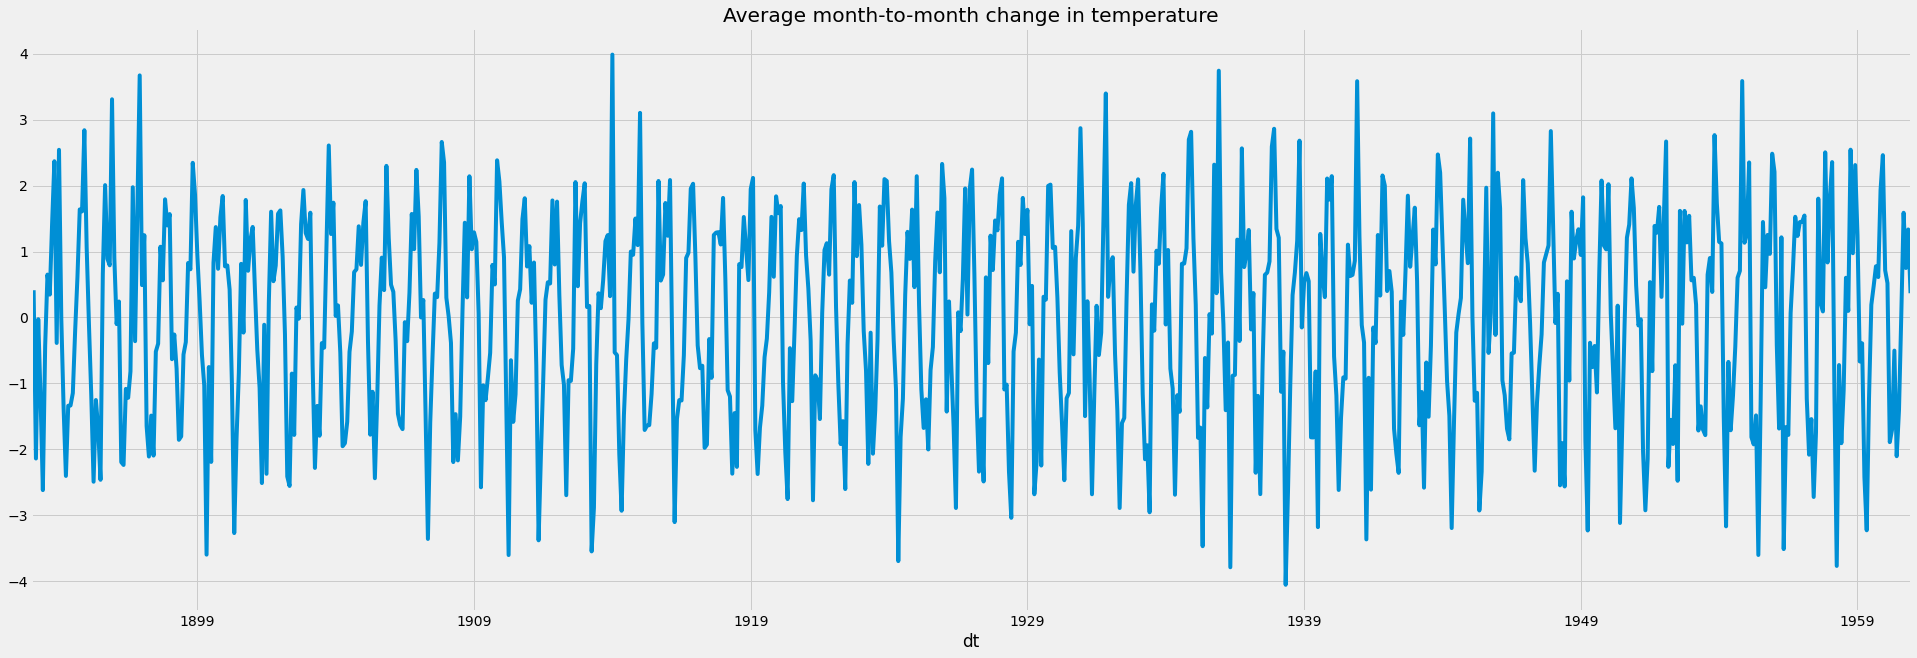

In [47]:
y.resample('M').mean().diff().plot(title='Average month-to-month change in temperature')

<AxesSubplot:title={'center':'Average Monthly Temperature by Year'}, xlabel='dt'>

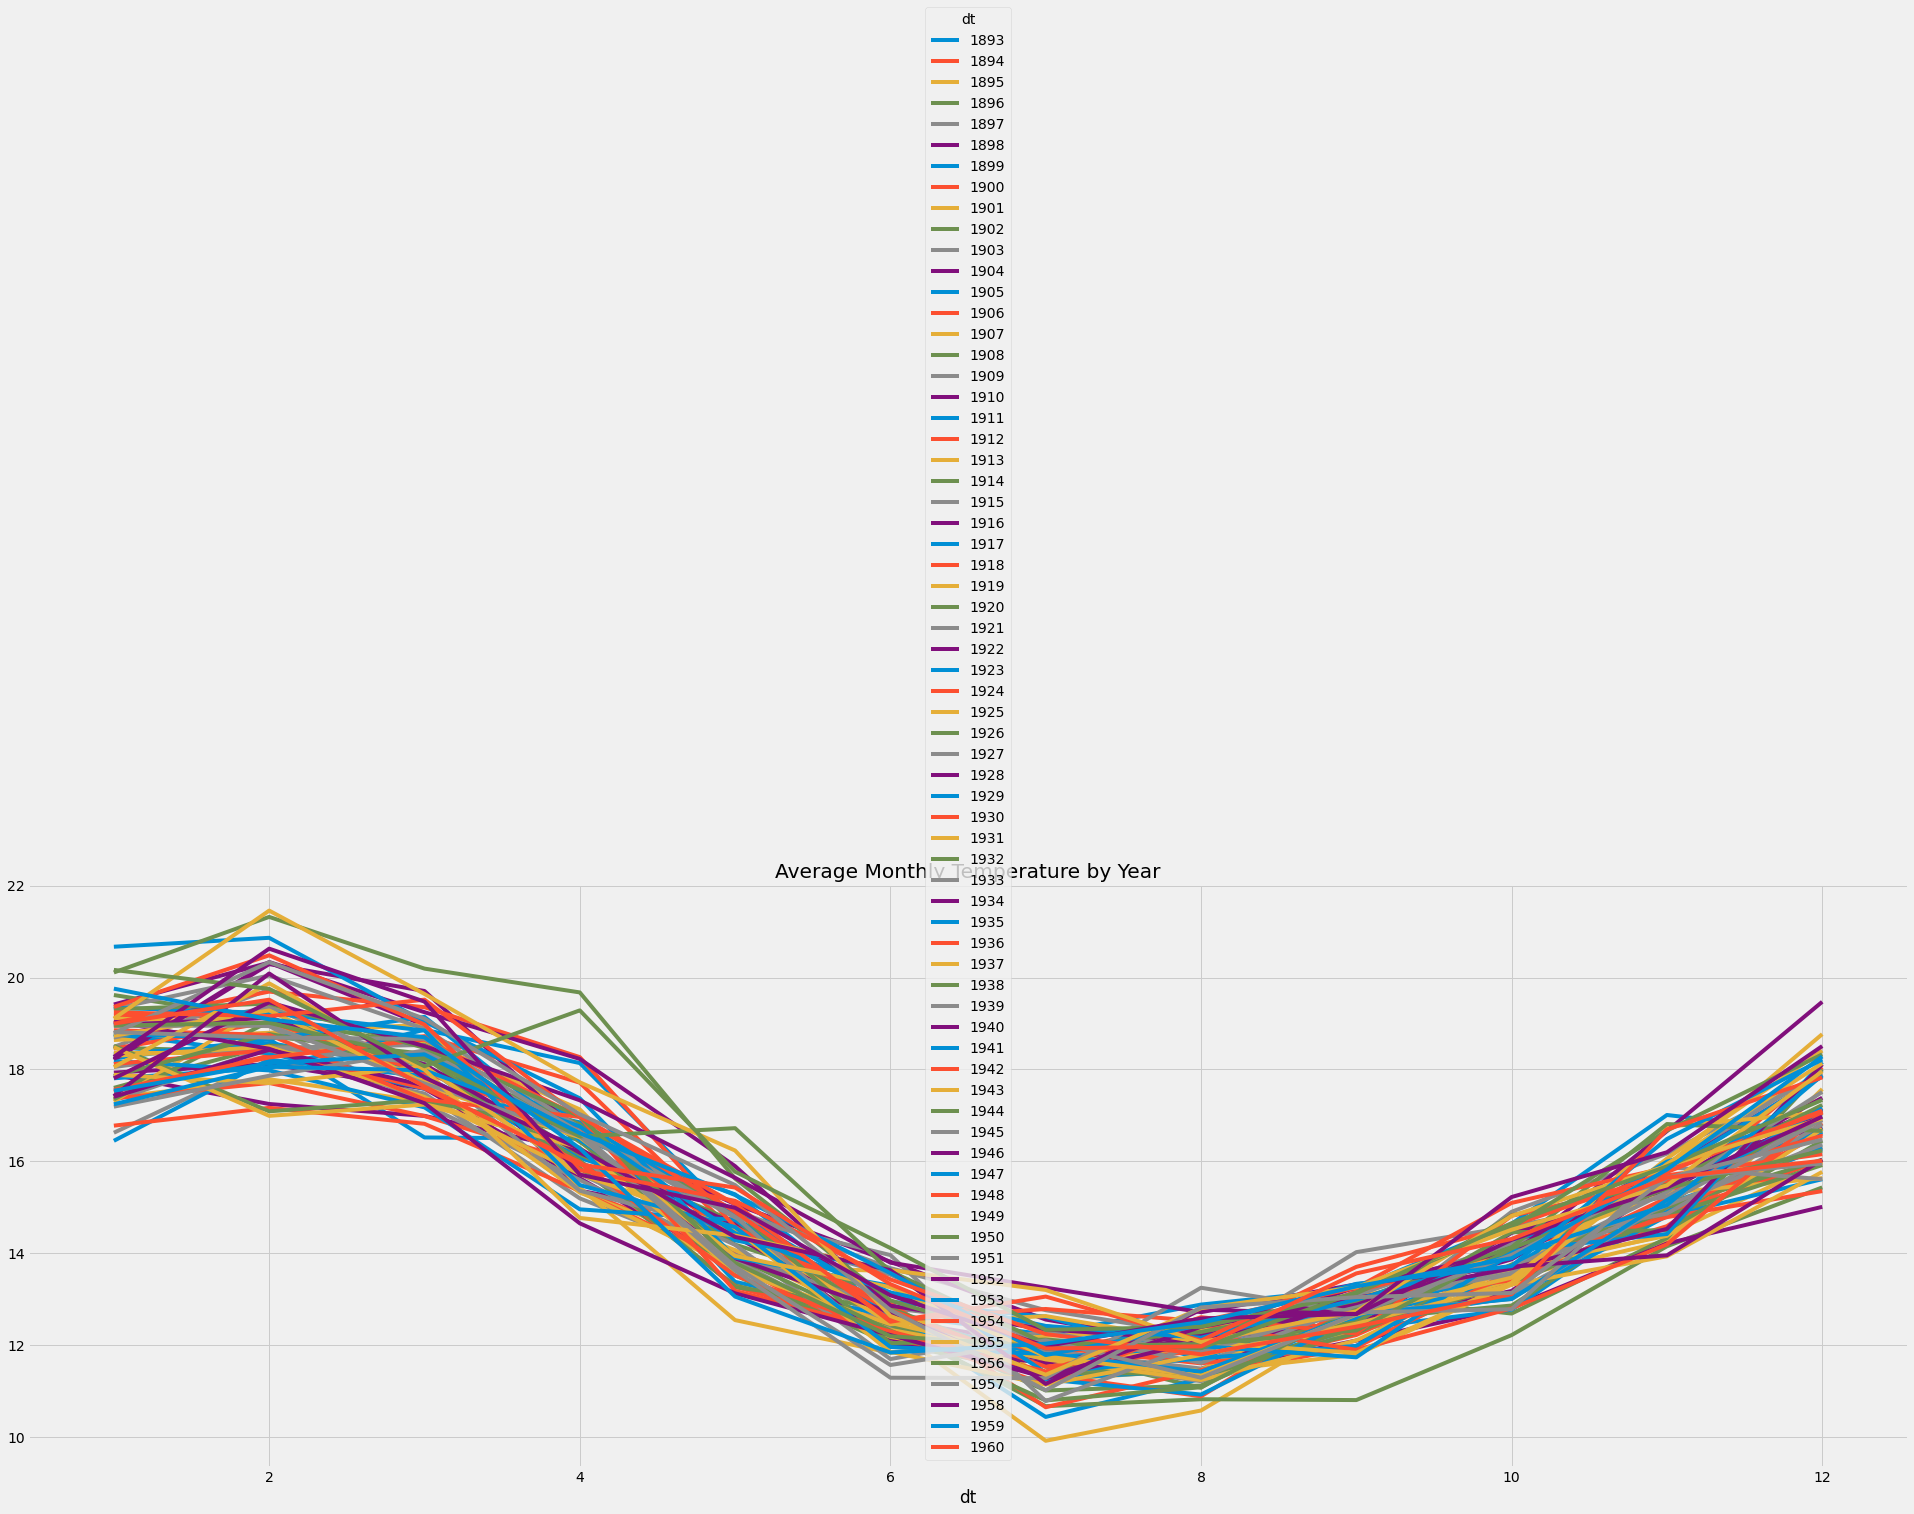

In [48]:
y.groupby([y.index.year, y.index.month]).mean().unstack(0).plot(title="Average Monthly Temperature by Year")

In [49]:
table = y.groupby([y.index.year, y.index.month]).mean().unstack()
table

dt        1       2       3       4       5       6       7       8       9   \
dt                                                                             
1893  18.244  18.657  16.520  16.494  15.282  12.666  12.234  12.884  13.231   
1894  19.164  19.145  17.774  15.373  14.035  12.701  11.556  11.349  11.959   
1895  19.107  18.994  17.809  15.320  14.069  12.380   9.920  10.579  12.585   
1896  18.474  18.374  18.616  16.424  14.189  13.107  11.890  11.074  13.048   
1897  18.490  19.737  18.092  15.985  14.498  12.405  11.888  11.492  12.564   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1956  20.166  19.753  18.070  19.285  15.775  14.114  12.334  12.400  13.129   
1957  18.789  20.334  19.104  17.025  15.485  12.765  11.020  12.821  13.045   
1958  18.273  20.628  19.476  15.711  14.990  13.085  11.979  12.581  12.681   
1959  19.758  19.091  18.700  16.283  13.058  11.840  12.032  12.503  13.279   
1960  18.997  19.518  17.629  15.932  15.430  13.328  11.928  11.975  13.562   

dt        10      11      12  
dt                            
1893  14.641  17.009  16.623  
1894  13.597  15.205  18.043  
1895  13.475  14.266  17.573  
1896  12.689  14.330  17.999  
1897  13.127  14.918  16.313  
...      ...     ...     ...  
1956  14.655  15.891  17.337  
1957  13.137  15.640  16.474  
1958  15.224  16.198  18.508  
1959  13.892  15.822  18.282  
1960  14.312  15.646  16.014  

[68 rows x 12 columns]

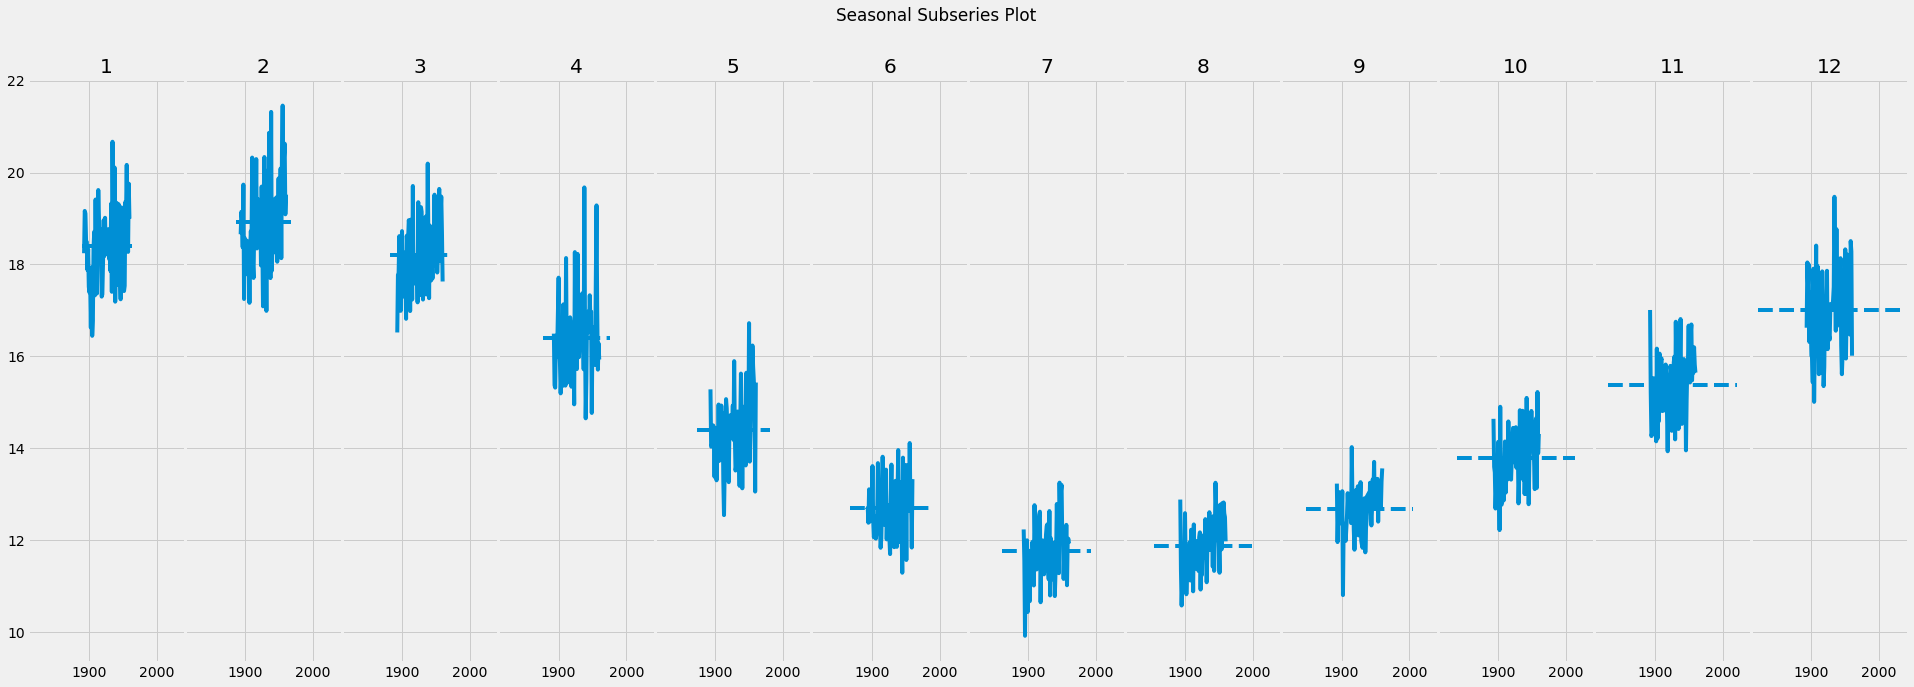

In [50]:
#make 12 subplot and share axis
fig, axs = plt.subplots(1, 12, sharey=True, sharex=True)

#gets 1st axis and 1st column of table
for ax, (month, subset) in zip(axs, table.iteritems()):
    
    #plot
    subset.plot(ax=ax, title=month)
    x_left, x_right = ax.get_xlim()
    ax.hlines(subset.mean(), x_left, x_right, ls='--')
    ax.set(xlabel='')

fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
fig.subplots_adjust(wspace=0)

this_week  month  12_weeks_out
dt                                        
1893-01-01     18.244    1.0           NaN
1893-01-08        NaN    NaN        16.494
1893-01-15        NaN    NaN           NaN
1893-01-22        NaN    NaN           NaN
1893-01-29        NaN    NaN           NaN
...               ...    ...           ...
1960-11-06     15.646   11.0           NaN
1960-11-13        NaN    NaN           NaN
1960-11-20        NaN    NaN           NaN
1960-11-27        NaN    NaN           NaN
1960-12-04     16.014   12.0           NaN

[3545 rows x 3 columns]

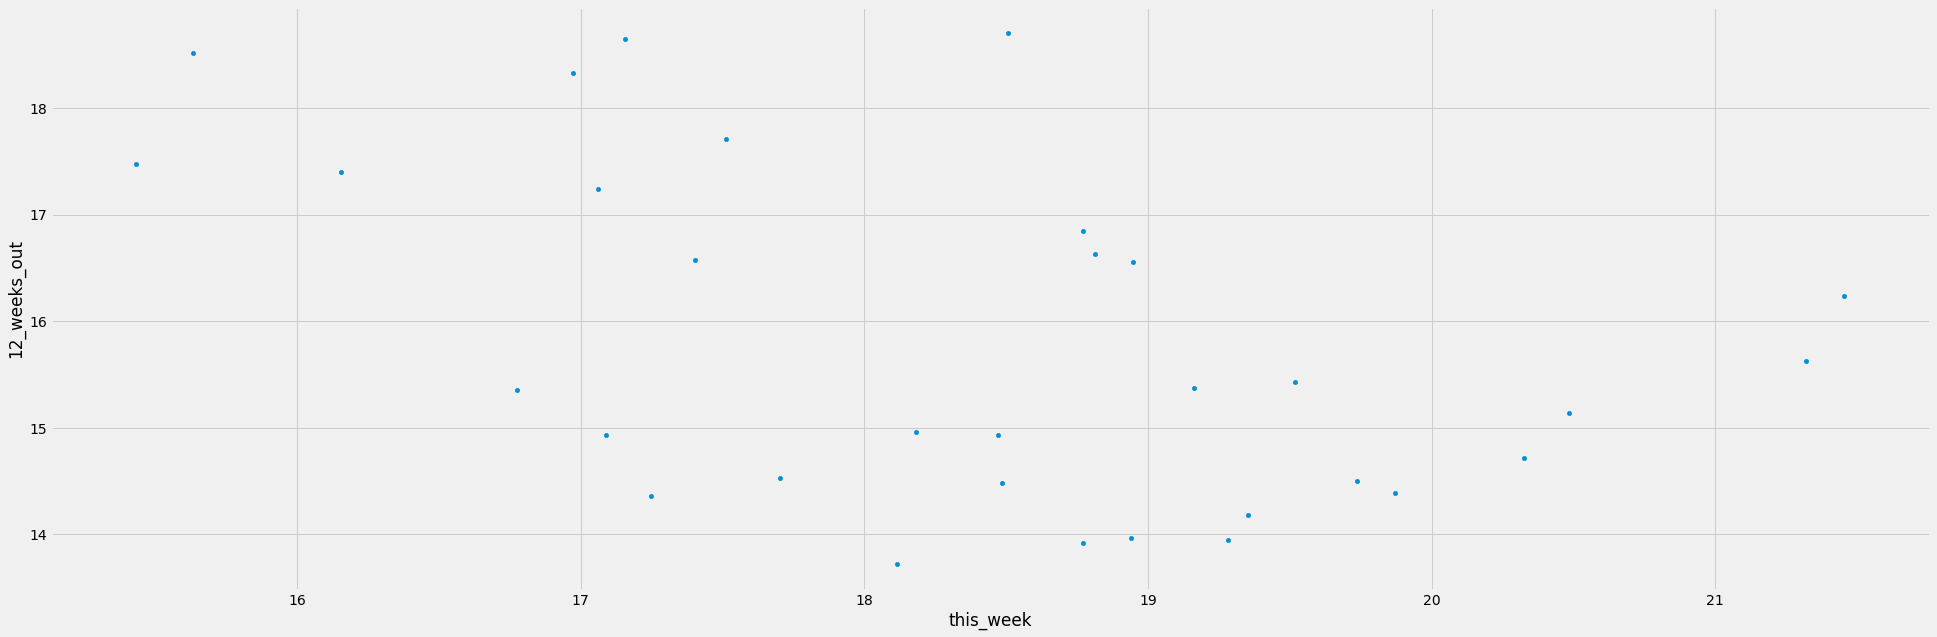

In [51]:
weekly = train.resample('W').mean()
weekly['12_weeks_out'] = weekly.avg_temp.shift(-12)
weekly = weekly.rename(columns={'avg_temp': 'this_week'})
weekly.plot.scatter(x='this_week', y='12_weeks_out')
weekly

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 52)'>

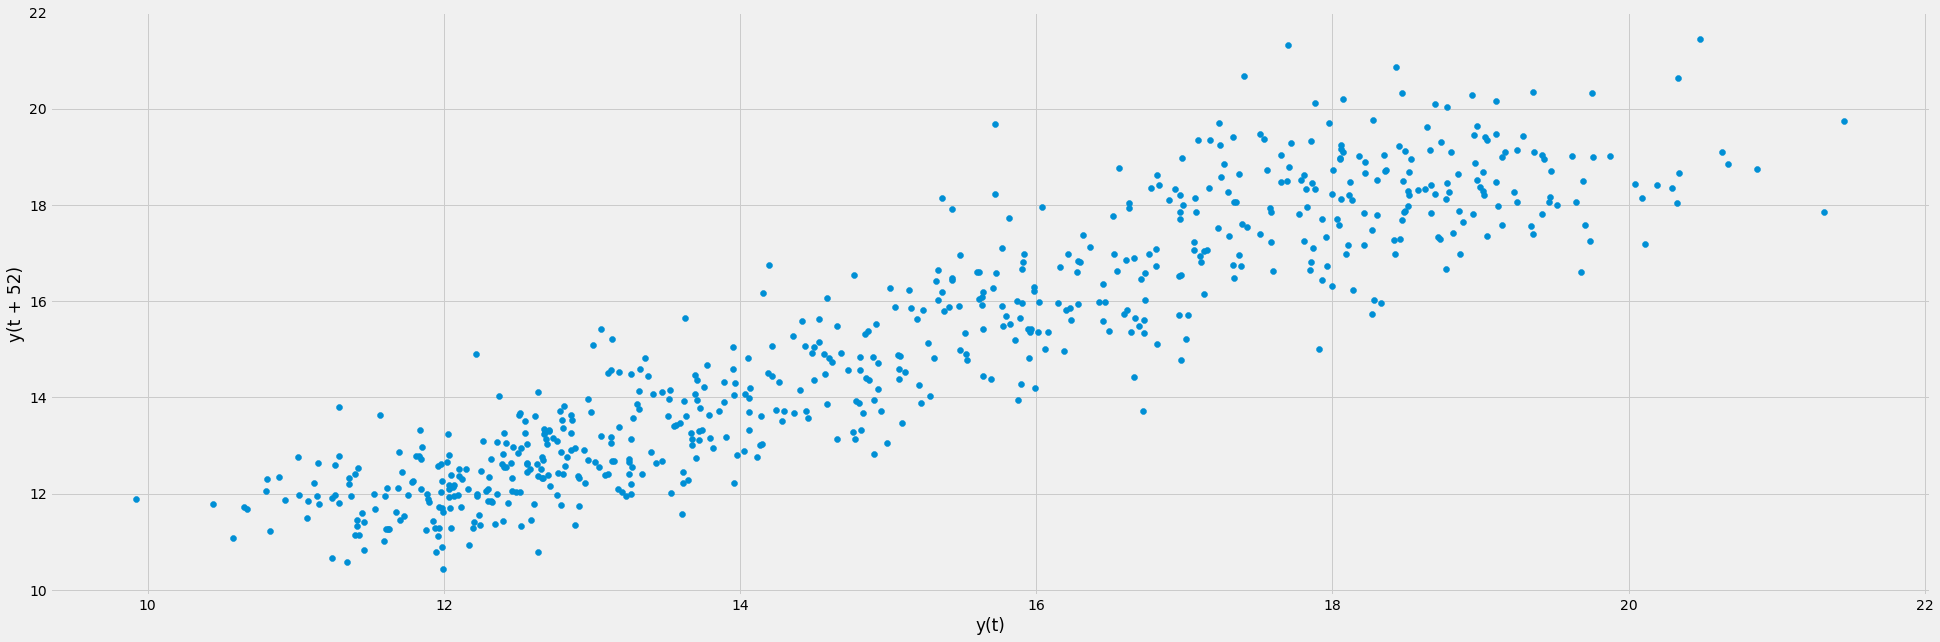

In [52]:
pd.plotting.lag_plot(train.avg_temp.resample('W').mean(), lag=52)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

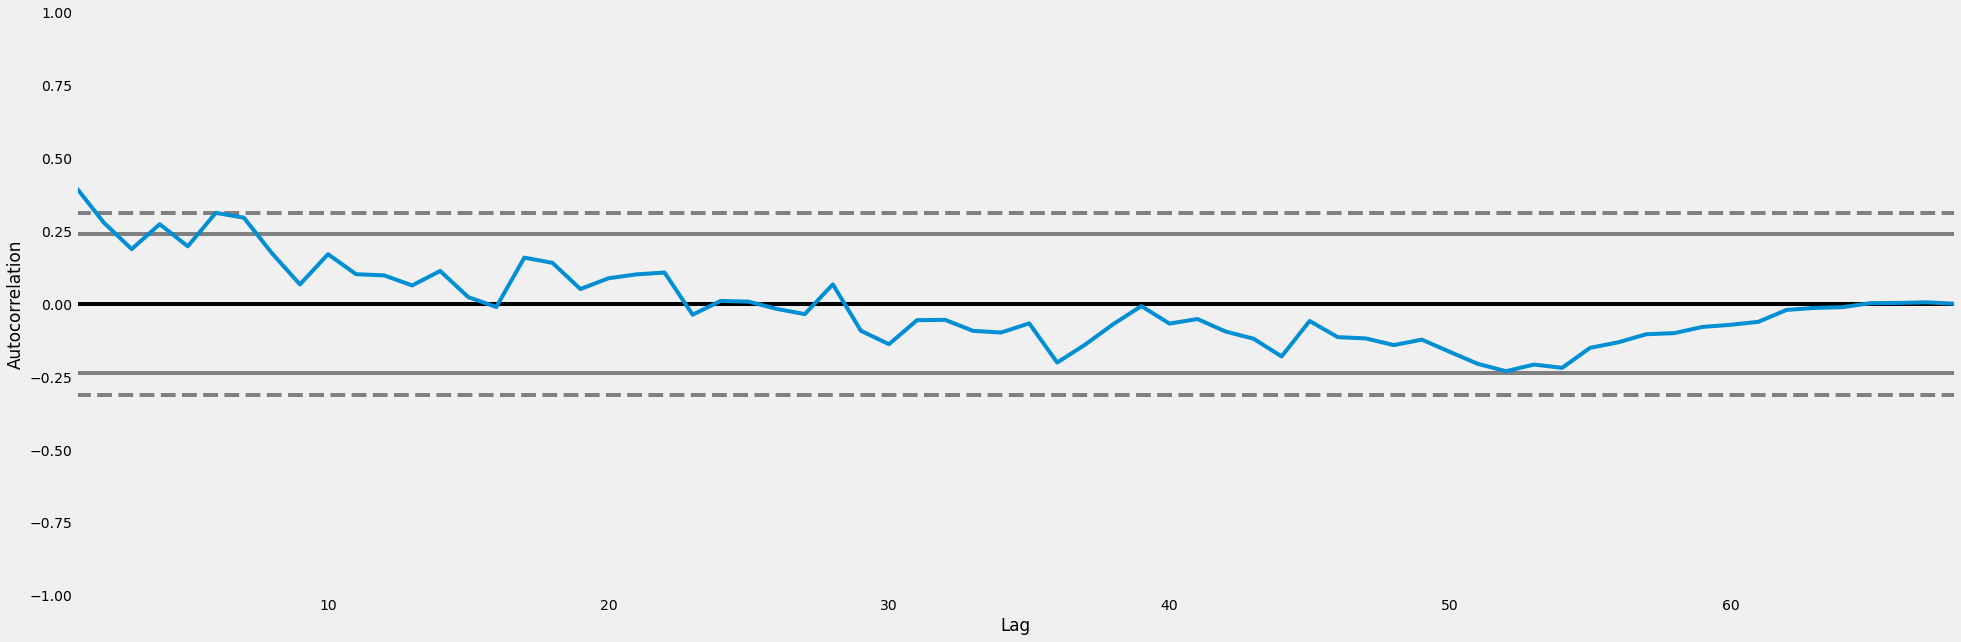

In [53]:
pd.plotting.autocorrelation_plot(train.avg_temp.resample('Y').mean())

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

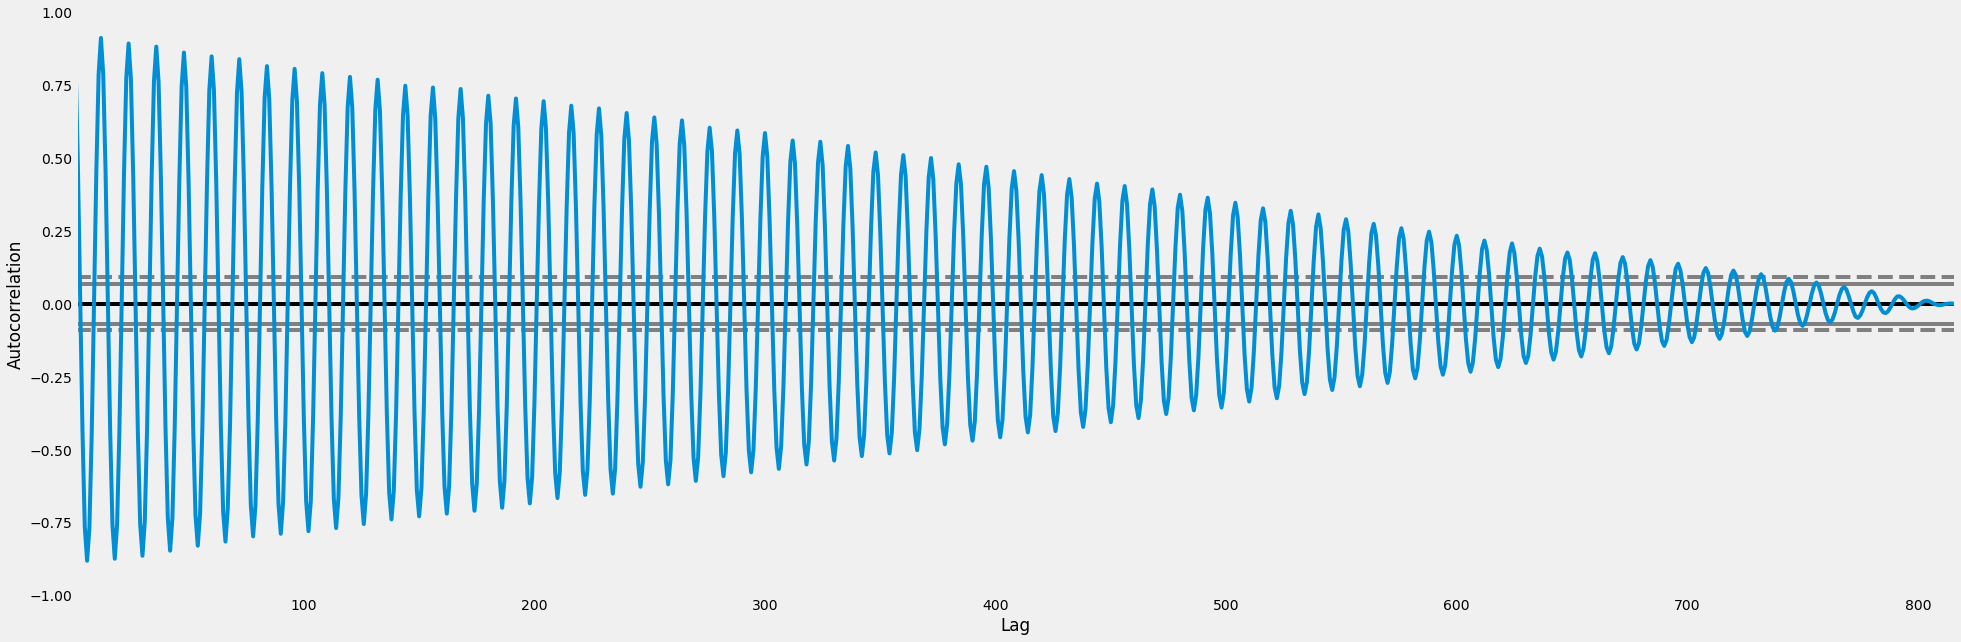

In [54]:
pd.plotting.autocorrelation_plot(train.avg_temp.resample('M').mean())

In [55]:
y = train.avg_temp.resample('M').mean()

result = sm.tsa.seasonal_decompose(y)
result

In [56]:
# Make a dataframe:

decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.head()

y  trend  seasonal  resid
dt                                        
1893-01-31  18.244    NaN  3.276432    NaN
1893-02-28  18.657    NaN  3.807725    NaN
1893-03-31  16.520    NaN  3.098532    NaN
1893-04-30  16.494    NaN  1.277441    NaN
1893-05-31  15.282    NaN -0.748999    NaN

<AxesSubplot:xlabel='dt'>

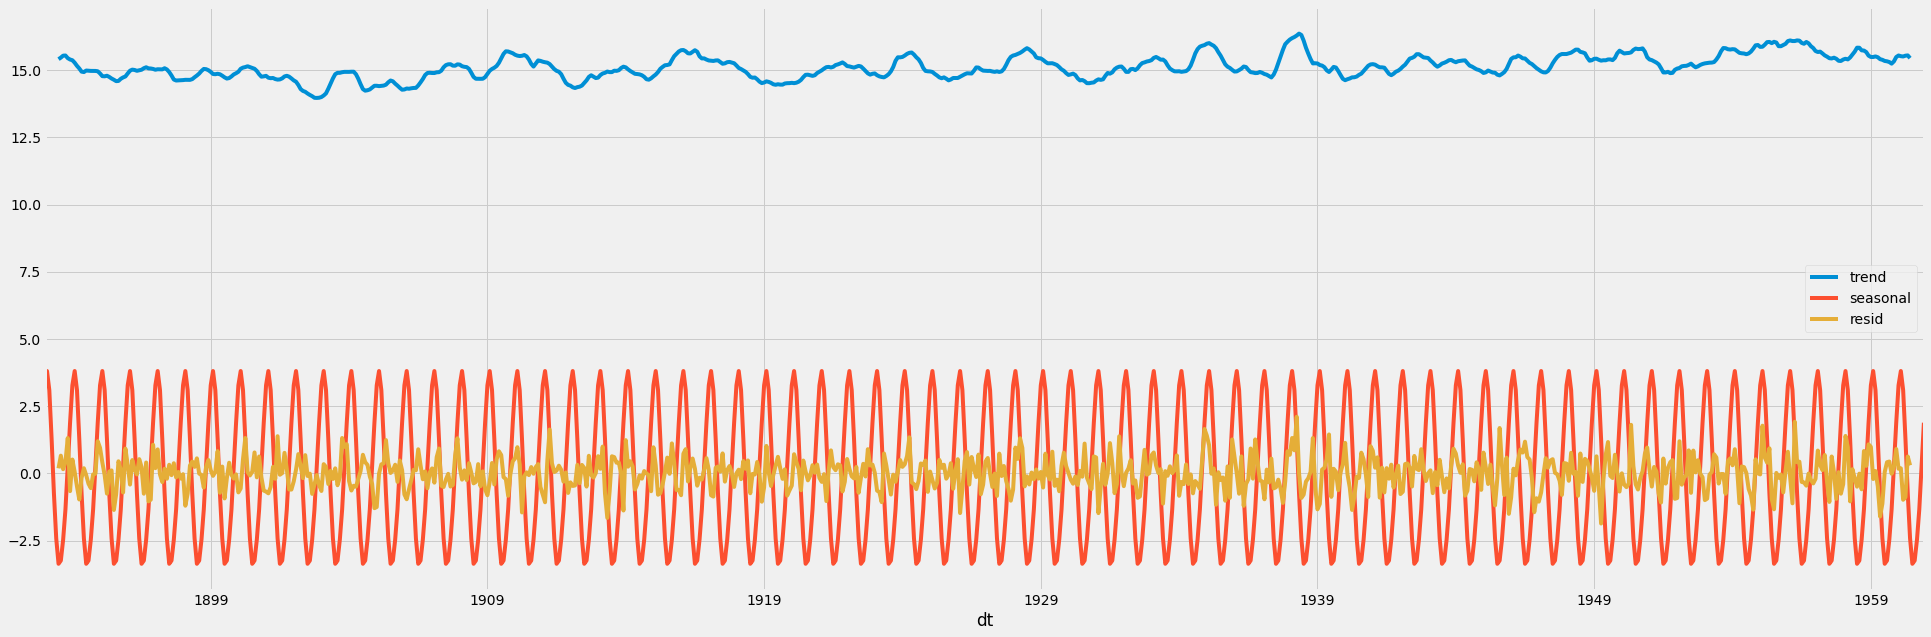

In [57]:
decomposition.iloc[:, 1:].plot()

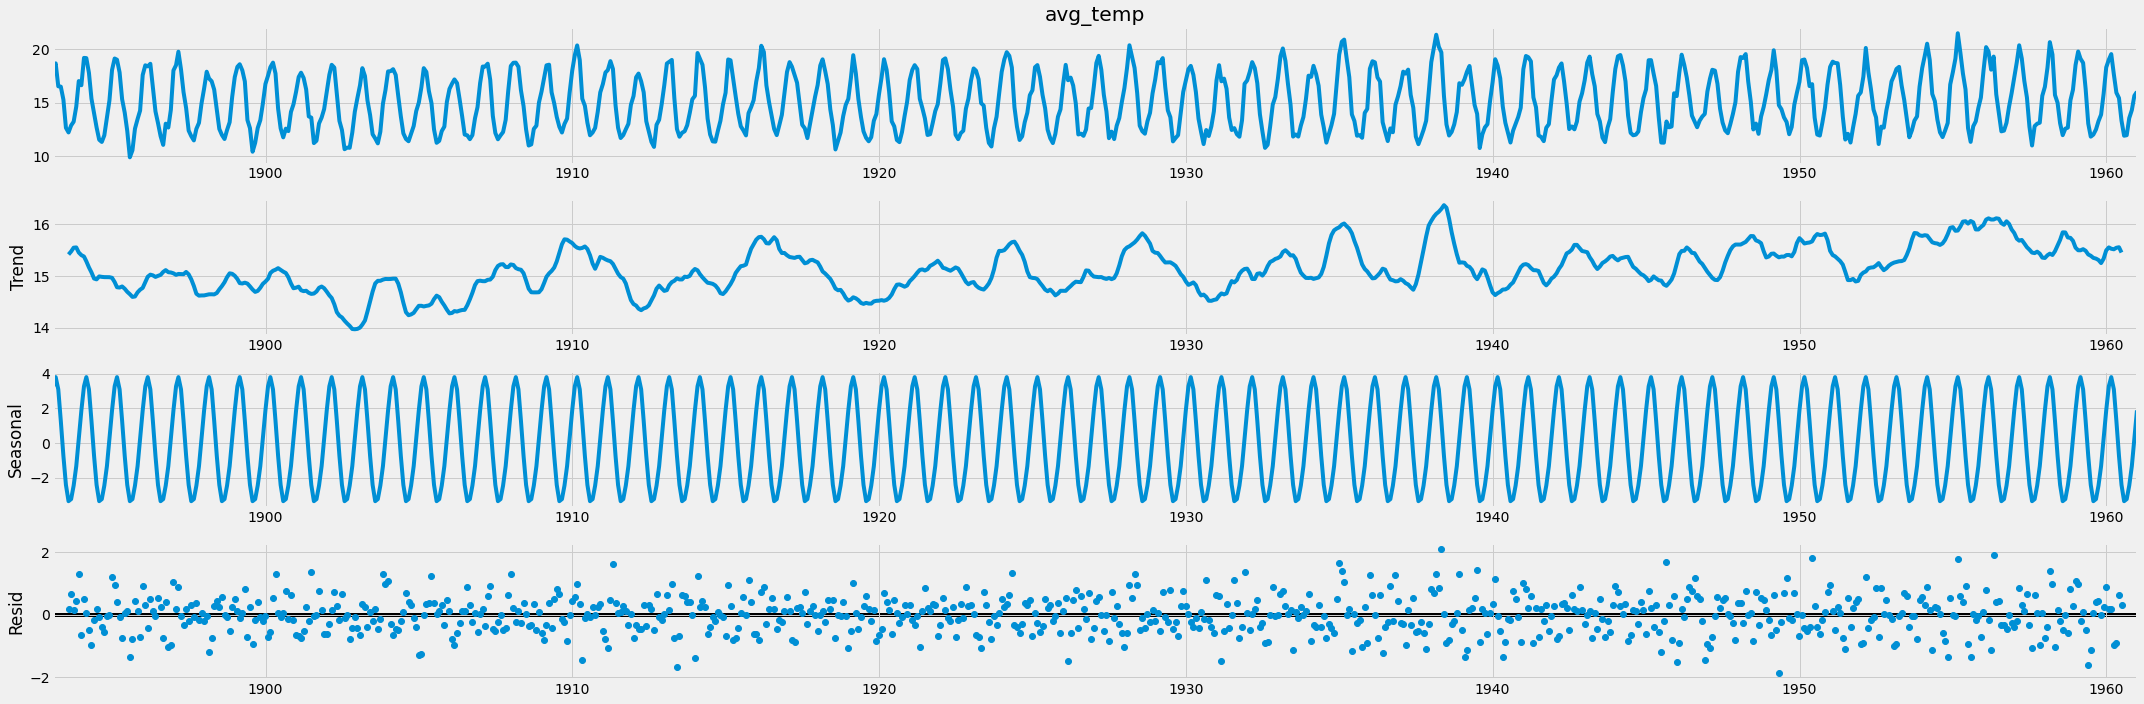

In [58]:
# the value returned from seasonal_decompose can itself be plotted:
result.plot()
None

In [59]:
train['season'] = ((train.index.month%12 + 3)//3)

In [60]:
train.season.replace([1, 2, 3, 4], ['Summer', 'Autumn', 'Winter', 'Spring'])

dt
1893-01-01    Summer
1893-02-01    Summer
1893-03-01    Autumn
1893-04-01    Autumn
1893-05-01    Autumn
               ...  
1960-08-01    Winter
1960-09-01    Spring
1960-10-01    Spring
1960-11-01    Spring
1960-12-01    Summer
Name: season, Length: 816, dtype: object

In [61]:
train['season'] = train.season.replace([1, 2, 3, 4], ['Summer', 'Autumn', 'Winter', 'Spring'])

In [62]:
train.head(2)

avg_temp    weekday  month  season
dt                                            
1893-01-01    18.244     Sunday      1  Summer
1893-02-01    18.657  Wednesday      2  Summer

<AxesSubplot:xlabel='dt'>

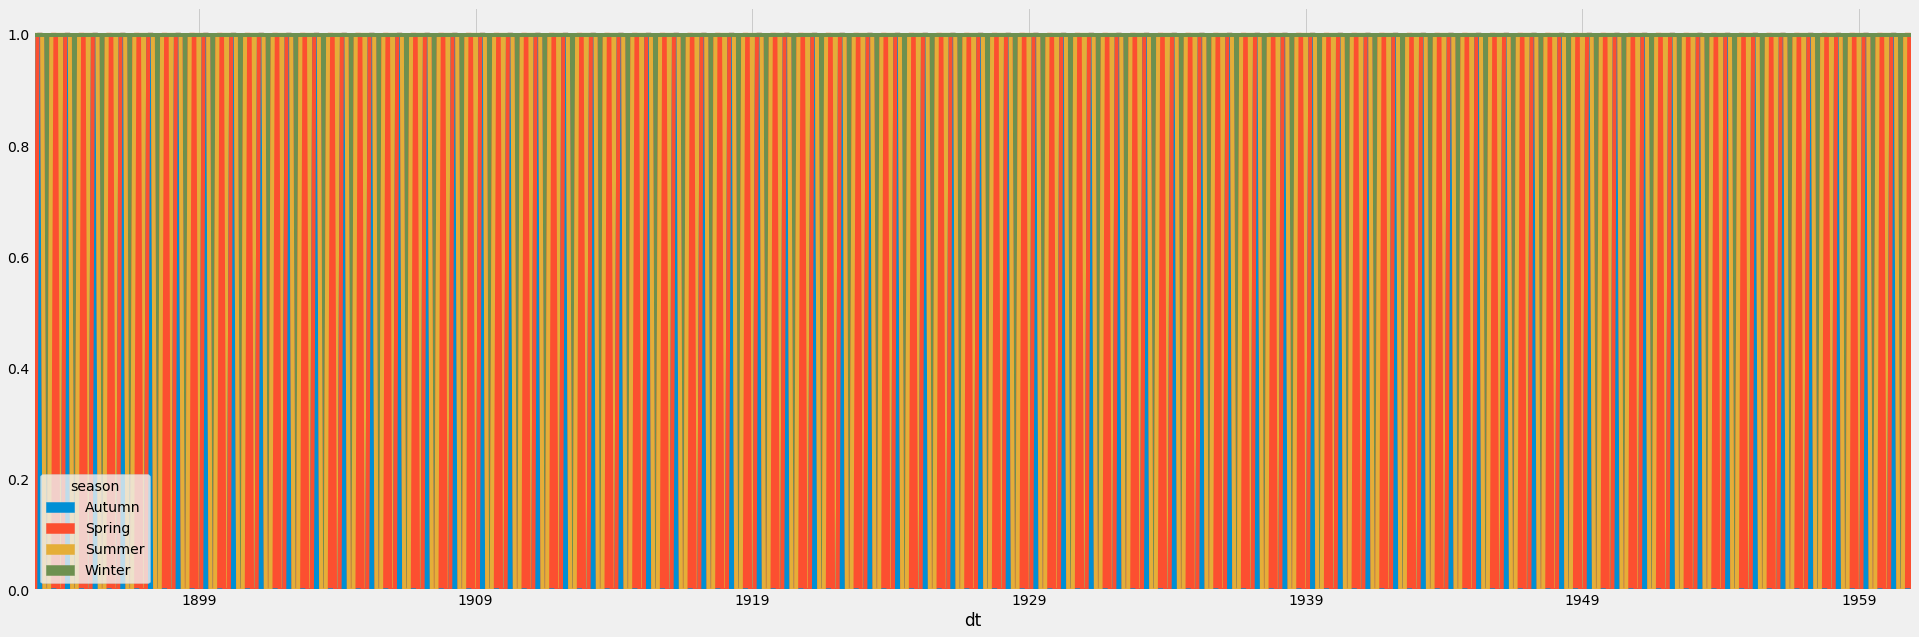

In [65]:
train.groupby('season').resample('M').size().unstack(0).fillna(0).apply(lambda row: row / row.sum(), axis=1).plot.area()

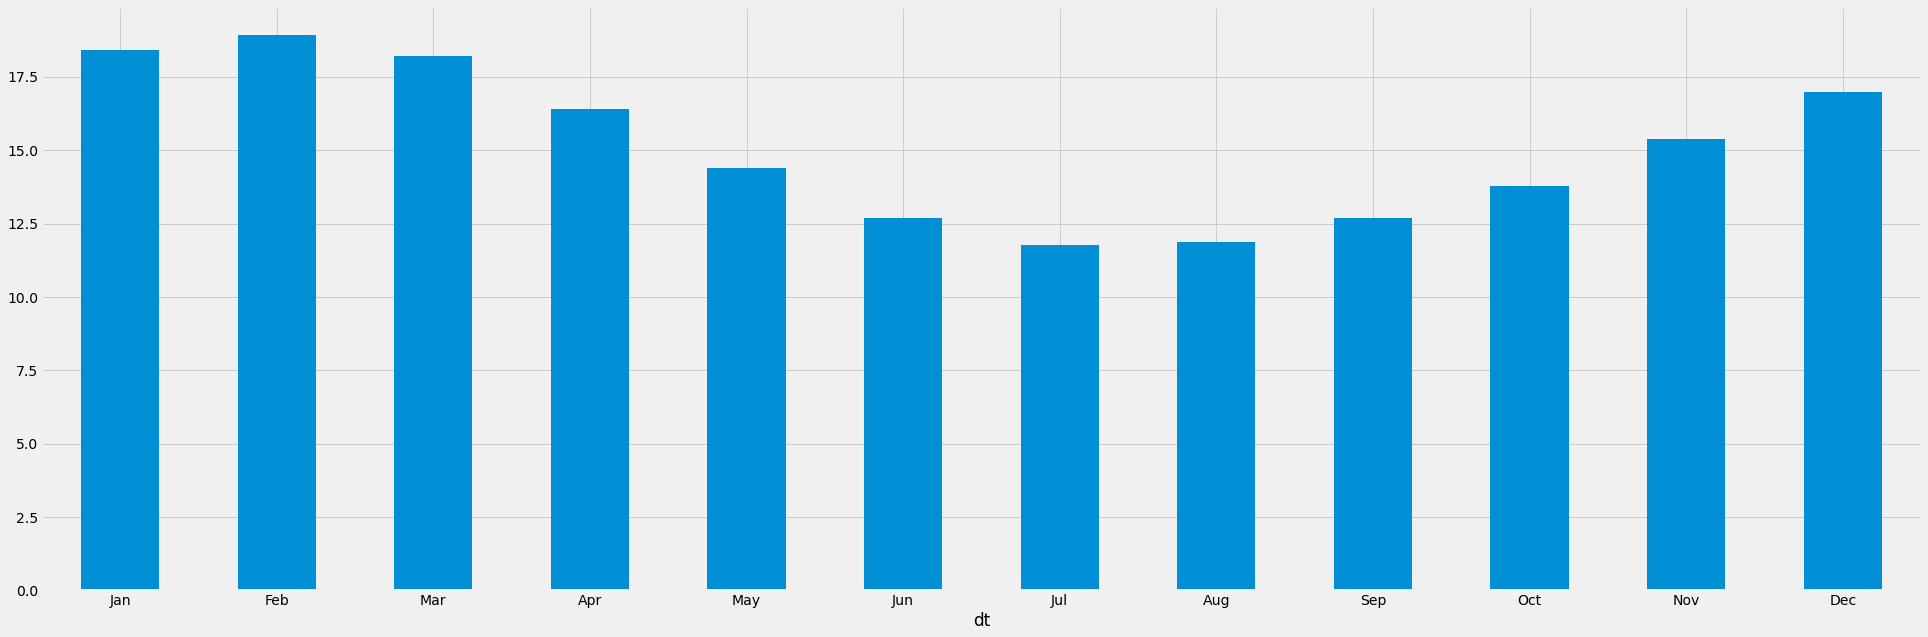

In [69]:
ax = y.groupby(y.index.strftime('%m-%b')).mean().plot.bar()
ax.set_xticklabels([t.get_text()[3:] for t in ax.get_xticklabels()], rotation=0);

[Jump to Table of Contents](#toc)
___
# <a name="modeling"></a>5. Modeling

[Jump to Table of Contents](#toc)

<a id='bottom'></a>